In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Data Set

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Practises/SeoulBikeData.csv', encoding='Latin-1').drop(['Date','Holiday','Seasons'], axis=1)
df.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [ ]:
df.columns = cols
df['functional'] = (df['functional'] == "Yes").astype(int)
df = df[df['hour']==12]
df = df.drop(['hour'], axis=1)
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


In [ ]:
for col in df.columns[1:]:
  plt.scatter (df[col],df['bike_count'])
  plt.title(col)
  plt.xlabel(col)
  plt.ylabel('bike_count_at_noon')
  plt.legend()
  plt.show()

In [ ]:
df = df.drop(['wind','visibility', 'functional'], axis = 1)
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


### Train Test Valid

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(len(df)*0.6), int(len(df)*0.8)])

In [ ]:
def xy_split(dataf, y_label, x_labels=None):
  dataf_new = copy.deepcopy(dataf)

  if x_labels is None:
    x_data = dataf_new[[l for l in dataf.columns if l != y_label]].values
  else:
    if len(x_labels) == 1:
      x_data = dataf_new[x_labels[0]].values.reshape(-1,1)
    else:
      x_data = dataf_new[x_labels].values

  y_data = dataf_new[y_label].values.reshape(-1,1)
  data = np.hstack((x_data,y_data))

  return data, x_data, y_data

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(len(df)*0.6), int(len(df)*0.8)])

_, x_train_temp, y_train_temp,  = xy_split(train, 'bike_count', x_labels=['temp'])
_, x_val_temp, y_val_temp,  = xy_split(val, 'bike_count', x_labels=['temp'])
_, x_test_temp, y_test_temp,  = xy_split(test, 'bike_count', x_labels=['temp'])

_, x_train, y_train = xy_split(train, 'bike_count', x_labels=df.columns[1:])
_, x_test, y_test = xy_split(test, 'bike_count', x_labels=df.columns[1:])
_, x_val, y_val = xy_split(val, 'bike_count', x_labels=df.columns[1:])

### Simple Linear Reg

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [ ]:
print(lin_reg.coef_, lin_reg.intercept_)

[[20.27201569]] [378.78554307]


In [ ]:
lin_reg.score(x_test_temp, y_test_temp) #higher this val higher these numbers corelate

0.2528114586504392

In [ ]:
y_preds = lin_reg.predict(x_test_temp)

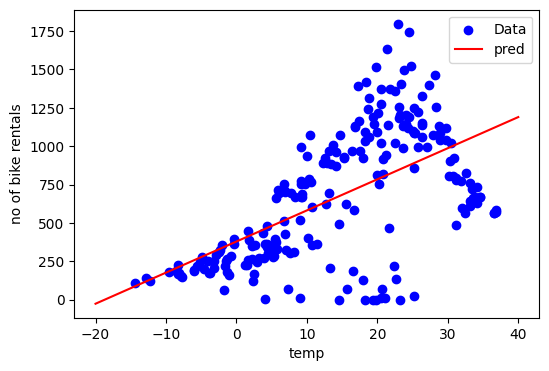

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(x_train_temp, y_train_temp, label = 'Data', color='Blue')
plt.xlabel('temp')
plt.ylabel('no of bike rentals')

x = tf.linspace(-20,40,100)
plt.plot(x, lin_reg.predict(np.array(x).reshape(-1,1)), label = 'pred', color = 'red')

plt.legend()
plt.show()

In [ ]:
mean_squared_error(lin_reg.predict(x_val_temp), y_val_temp)

122683.64617809992

### Multiple Linear Regression

In [ ]:
mult_lin_reg = LinearRegression()
mult_lin_reg.fit(x_train,y_train)

LinearRegression()

In [ ]:
mult_lin_reg.score(x_test,y_test)

0.47223416877354996

In [ ]:
print(mult_lin_reg.coef_, mult_lin_reg.intercept_)

[[ -8.46168684 -11.57060487  28.23270307  93.74528236 -24.2292218
   -2.57607746]] [1115.02533457]


In [ ]:
mean_squared_error(mult_lin_reg.predict(x_val), y_val)

100171.57119783557

### neural networks for simple linear regression





In [ ]:
def plot_loss(history):
  plt.figure(figsize=(5,3))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('epochs')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1) # having just one node as well as not having an activation function makes the network linear
])

temp_nn_model.compile(
    loss = "mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1)
)

history = temp_nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    epochs = 1000,
    validation_data = (x_val_temp.reshape(-1),y_val_temp),
    verbose = 0
    )


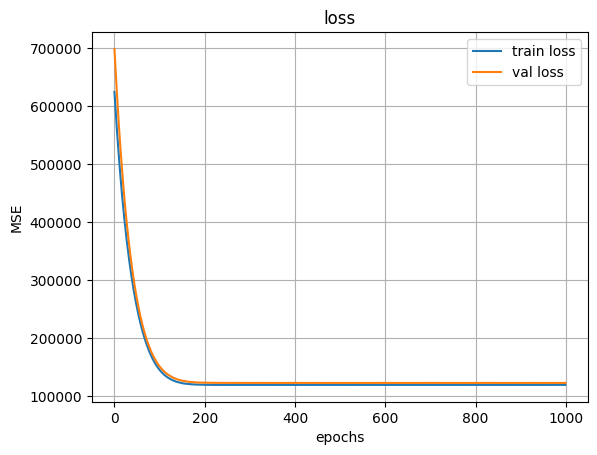

In [ ]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


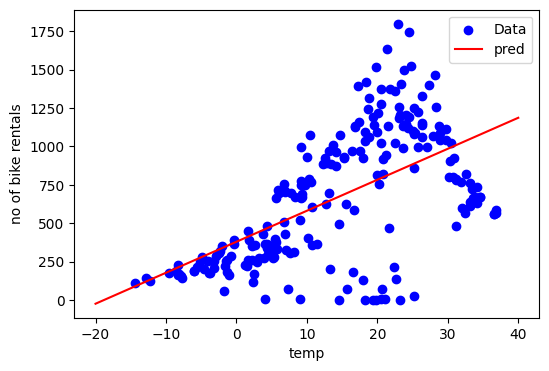

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(x_train_temp, y_train_temp, label = 'Data', color='Blue')
plt.xlabel('temp')
plt.ylabel('no of bike rentals')

x = tf.linspace(-20,40,100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label = 'pred', color = 'red')

plt.legend()
plt.show()

In [ ]:
temp_nn_model.evaluate(x_val_temp,y_val_temp)

3/3 [==============================] - 0s 4ms/step - loss: 122764.2891


122764.2890625

Learning rarte vs mse vs epochs to converge

0.1 - 139827.984375 - 1000

1 - 136041.515625 - 200

0.01 - 509329.4375 - 1000 (linear graph)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(temp_nn_model.predict(x_val_temp),y_val_temp)

3/3 [==============================] - 0s 5ms/step


577223.5127878626

### neural net multiple linear reg

In [ ]:
multi_nn_norm = tf.keras.layers.Normalization(input_shape=(6,), axis=None)
multi_nn_norm.adapt(x_train)

multi_reg_nn_model = tf.keras.Sequential([
    multi_nn_norm,
    tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='relu')
])

multi_reg_nn_model.compile(
    loss = 'mean_squared_error',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

history = multi_reg_nn_model.fit(
    x_train,y_train,
    validation_data=(x_val,y_val),
    epochs=100,
    # batch_size=
    verbose=0,
)


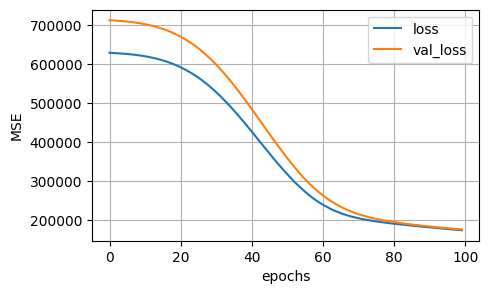

In [ ]:
plot_loss(history)

In [ ]:
multi_reg_nn_model.evaluate(x_val,y_val)

3/3 [==============================] - 0s 6ms/step - loss: 176013.8906


176013.890625

### neural networks for simple linear regression 2

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(5,3))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('epochs')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

temp_nn_model.compile(
    loss = "mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
)

history = temp_nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    epochs = 100,
    validation_data = (x_val_temp.reshape(-1),y_val_temp),
    verbose = 0
    )


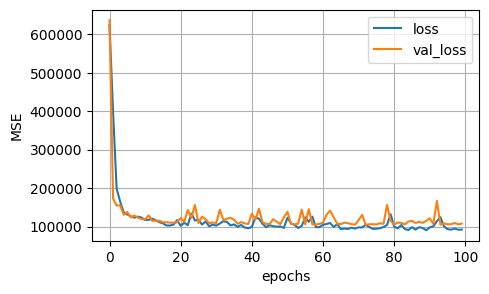

In [ ]:
plot_loss(history)

In [ ]:
temp_nn_model.evaluate(x_val_temp,y_val_temp)

3/3 [==============================] - 1s 10ms/step - loss: 107662.1250


107662.125

4/4 [==============================] - 0s 13ms/step


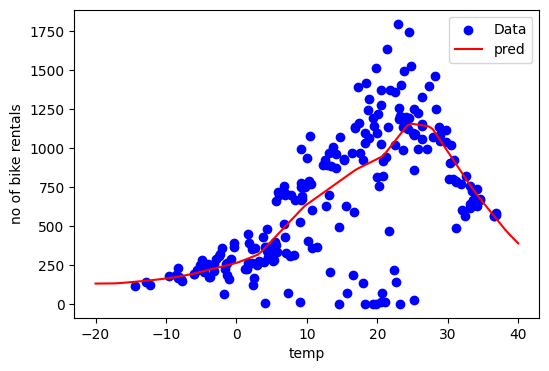

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(x_train_temp, y_train_temp, label = 'Data', color='Blue')
plt.xlabel('temp')
plt.ylabel('no of bike rentals')

x = tf.linspace(-20,40,100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label = 'pred', color = 'red')

plt.legend()
plt.show()

### neural net multiple linear reg 2

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='val loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.ylabel('MSE')
  plt.grid(True)
  plt.legend()
  plt.show()

In [ ]:
x_train.shape

(219, 6)

In [ ]:
multi_reg_nn_normalizer_2 = tf.keras.layers.Normalization(input_shape=(6,),axis=None)
multi_reg_nn_normalizer_2.adapt(x_train)

multi_reg_nn_model = tf.keras.Sequential([
    multi_reg_nn_normalizer_2,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

multi_reg_nn_model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'mean_squared_error'
)

history = multi_reg_nn_model.fit(
  x_train, y_train,
  epochs = 100,
  # batch_size=
  validation_data = (x_val,y_val),
  verbose=0
)


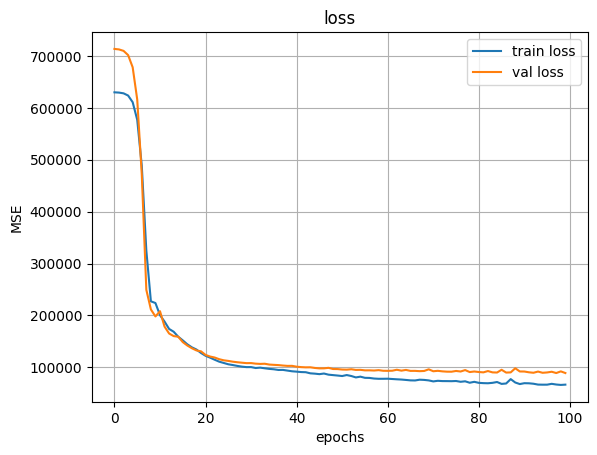

In [ ]:
plot_loss(history)

In [ ]:
multi_reg_nn_model.evaluate(x_val,y_val)

3/3 [==============================] - 0s 4ms/step - loss: 89162.2656


89162.265625

### comparing sklearn linear regression was neural net linear regression

In [ ]:
def mean_squared_error(y_preds,y_true):
  return (np.square(y_preds - y_true)).mean()

In [ ]:
y_preds_mult_lin_reg = mult_lin_reg.predict(x_val)
y_preds_multi_reg_nn_model = multi_reg_nn_model.predict(x_val)

3/3 [==============================] - 0s 3ms/step


In [ ]:
print(mean_squared_error(y_preds_mult_lin_reg,y_val))
print(mean_squared_error(y_preds_multi_reg_nn_model,y_val))

100171.57119783557
89162.27312836735


In [ ]:
df['bike_count'].max()

1798

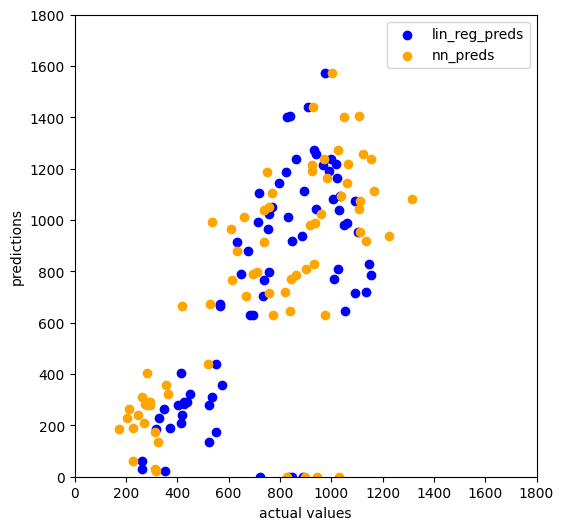

In [ ]:
plt.figure(figsize=(10,6))
ax = plt.axes(aspect='equal')
plt.scatter(y_preds_mult_lin_reg,y_val,label='lin_reg_preds',color='blue')
plt.scatter(y_preds_multi_reg_nn_model,y_val,label='nn_preds',color='orange')
plt.ylabel('predictions')
plt.xlabel('actual values')
limits=[0,1800]
plt.xlim(limits)
plt.ylim(limits)
plt.plot(y_val,y_val, label='', color='red')
plt.legend()
plt.show()